# Мастер-класс: Моделирование и Идентификация систем массового обслуживания
---
- моделирование и оценка необходимого минимального кол-ва обращений к сервису при известном проценте сбоев для достижения заданной надежности;

- моделирование и оценка необходимого кол-ва каналов обслуживания потока заявок при известной статистике поступления заявок на обслуживание;

- идентификация смеси распределения на основе анализа реальной статистики работы слушателей с онлайн-курсом физтеха.


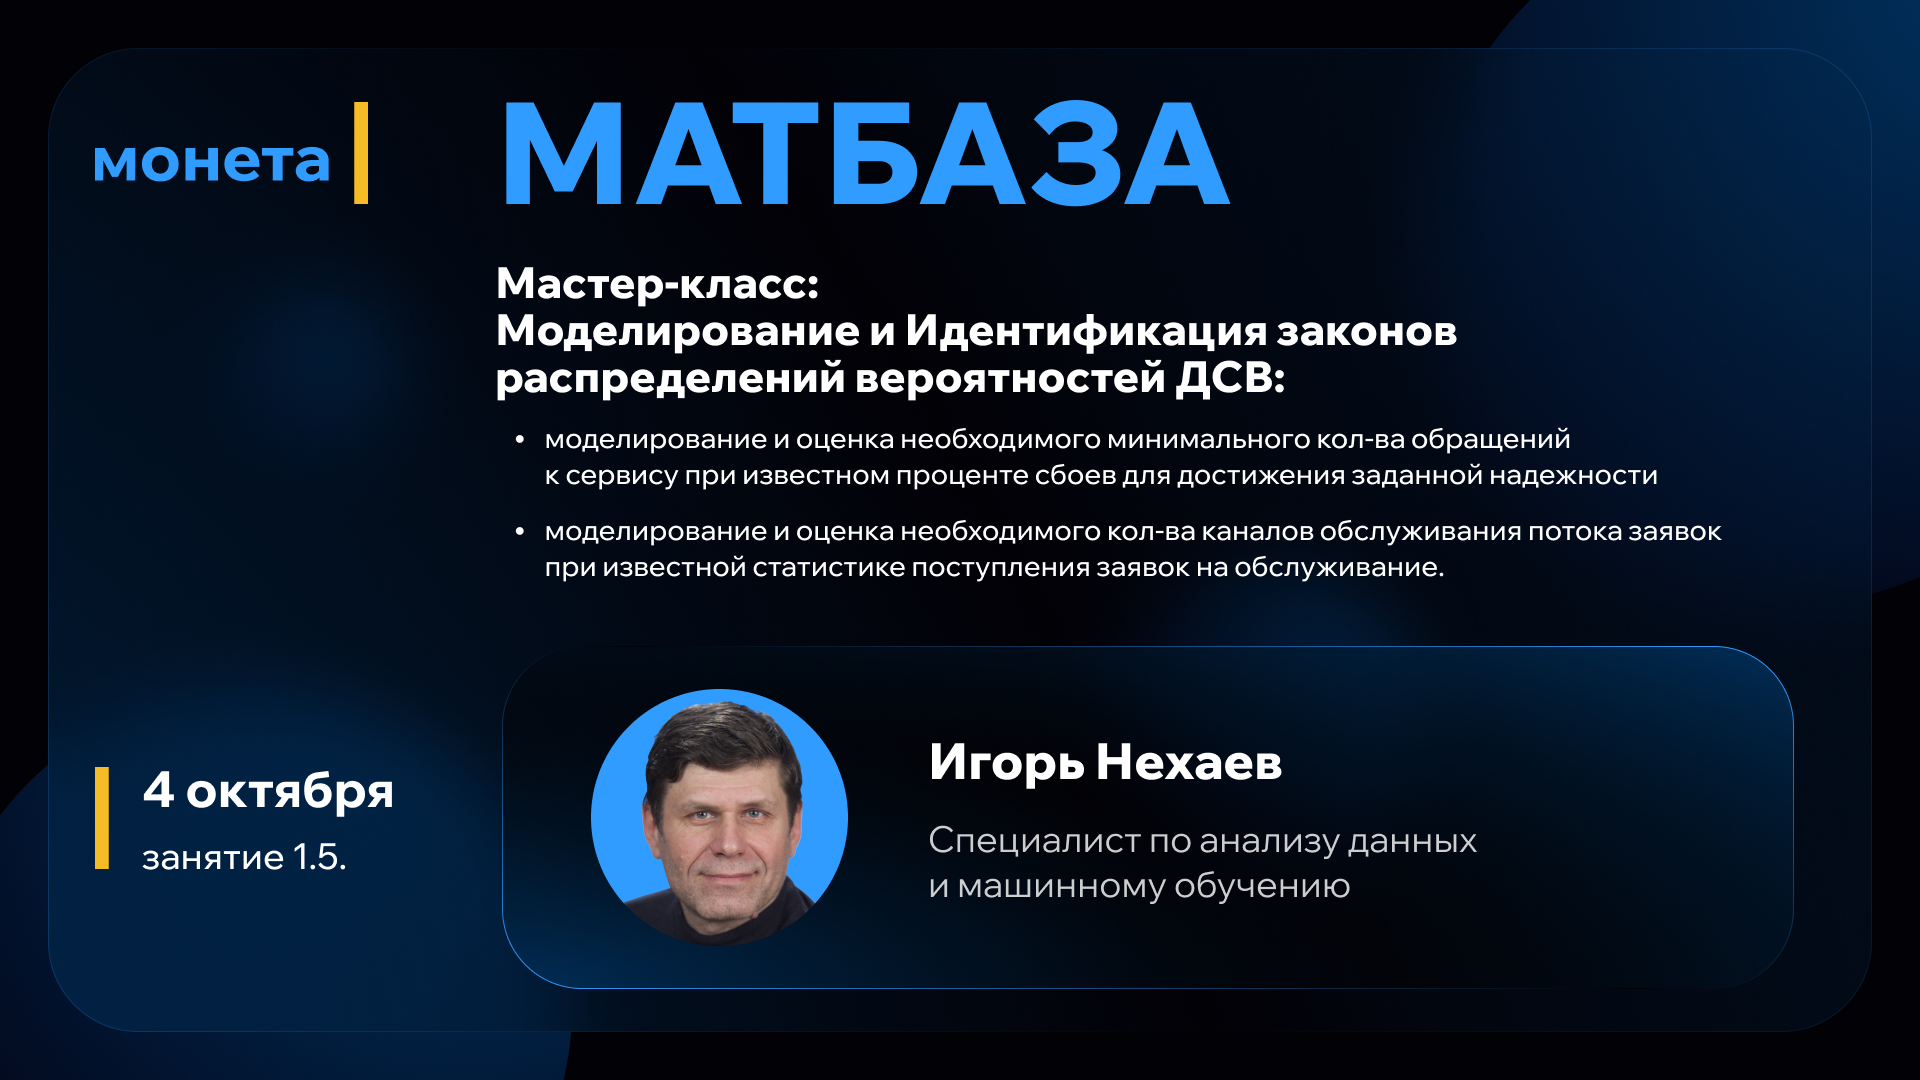

## Моделирование и оценка необходимого минимального кол-ва обращений к сервису при известном проценте сбоев для достижения заданной надежности
---

Попробуем применить наши знания для решения практико-ориентированных задач. Рассмотрим задачу обращения к перегруженному сервису. ДОпустим, у нас имеется статистика, что в среднем, из 100 обращений, поступающих на сервис, ответы приходят на 80, остальные 20 теряются.

Т.е мы можем постулировать, что

$$p(успеха) = 0.8$$

Нам надо оценить, сколько раз нам надо будет максимум обратиться, чтобы добиться успеха с требуемой надежностью (вероятностью) не менее 0.99.

т.е. имеем серию испытаний Бернулли до первого успеха:

$x_i$   | 1 | 2 | 3 |  4   | ...
--------|---|---|---|------|---
p($x_i$)|p|qp|$q^2p$|$q^3p$| ...


In [17]:
import numpy as np
import pandas as pd

N = 10
p = 0.8
q = 1 - p
neg_bin = np.ones(N) * p
neg_bin *= np.array([q**k for k in range(N)])
neg_bin = pd.Series(data=neg_bin, index=range(1, N+1))

neg_bin

1     8.000000e-01
2     1.600000e-01
3     3.200000e-02
4     6.400000e-03
5     1.280000e-03
6     2.560000e-04
7     5.120000e-05
8     1.024000e-05
9     2.048000e-06
10    4.096000e-07
dtype: float64

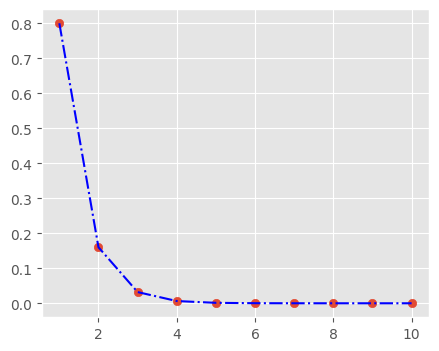

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.style.use('ggplot')

plt.scatter(x=range(1, N+1), y=neg_bin)
plt.plot(neg_bin, 'b-.');

### ВОПРОС. Обеспечить надежность повтором
---
Сколько раз нам надо будет максимум обратиться, чтобы добиться успеха с требуемой надежностью (вероятностью) не менее 0.99.

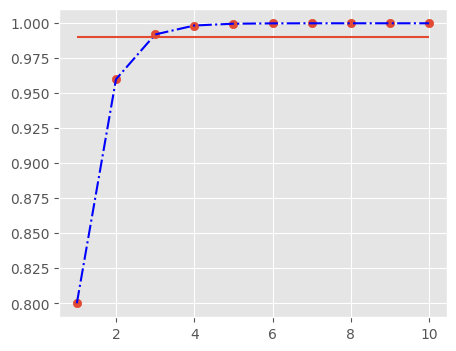

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.style.use('ggplot')

plt.scatter(x=range(1, N+1), y=neg_bin.cumsum())
plt.plot(neg_bin.cumsum(), 'b-.')
plt.hlines(0.99, xmin=1, xmax=N);

## Моделирование и оценка необходимого кол-ва каналов обслуживания потока заявок при известной статистике поступления заявок на обслуживание
---

Рассмотрим задачу массового обслуживания:
- идет поток заявок на обслуживание (обращения в службу поддержки клиентов, поток запросов к сервису, поток желающих посетить туалет, ...); нам известна его интенсивность (среднее кол-во в единицу времени);
- имеются обслуживающие юниты (люди, которые отвечают на звонки клиентов, обрабатывающий заявки сервер, кабинка в таулете, ...); нам известна статистика времени обслуживания, например, интенсивность обслуживания заявки одним юнитом - сколько в среднем заявок в единицу времени он обслуживает.

> Так как это случайные процессы (поступления заявок и обслуживание), то и результат обслуживания получается случайным. Нам хотелось бы получить его вероятностное описание. Оно нам может понадобится, чтобы получить ответы на следующие вопросы:
- какова может быть максимальная очередь зявок на обслуживание?
- если заявки не могут ждать в очереди, то какой процент заявок мы будем терять в среднем?
- сколько нам надо обслуживающих устройств, чтобы снизить процент потери заявок до допустимого?


### Пример. WC
----
Смоделируем работу мужского туалета в компании (примеры выбран из-за его всем понятности).

Пусть нам известно кол-во мужчин, работающих в офисе компании - 40 чел.
Каждый из них в среднем раза три за день ходит в WC (рассматриваем облегченный вариант облегчения). Получаем поток примерно в среднем 120 заявок на обслуживание за день, за 8 часов или в среднем 15 заявок в час.

Кабинка туалета справляется с заявкой (хотя это мы справляемся) в среднем за 2 мин. (не торопясь если).

Все бы хорошо, теоретически одна кабинка за час может обслужить очередь из 30 чел.
> НО:
- работники не хотят ждать (не выстраиваются в очередь);
- они приходят в WC не организованно, не упорядоченно, каждый в случайный момент времени.

Хотелось бы оценить вероятность того, что пришедший по нужде работник получит удовлетворение его заявки сразу (с точностью до минуты).

Для этого мы смоделируем поминутно случайный поток заявок на обслуживание и процесс обслуживания.

In [ ]:
# Загрузим библиотеку с вероятностными законами распределения
from scipy.stats import binom, poisson

def create_bin_prob(n, p):
    def bin_prob(k):
        return binom.pmf(k, n, p)
    return bin_prob

def create_poisson_prob(n, p):
    lamda = n * p
    def poisson_prob(k):
        return poisson.pmf(k, lamda)
    return poisson_prob

In [26]:
# Моделируем поток заявок как серию исптытаний Бернулли
query_per_hour_lamda = 15  # в час
p_query_per_min = query_per_hour_lamda / 60

query_flow = (np.random.random(60) < p_query_per_min) * 1
query_flow

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])

Для моделирования времени обслуживания нам понадобится закон распределения непрерывной СВ. Можчно использовать экспоненциальное распределение, которое задается интенсивностью наступления события.

Это распределение использует тот же параметр, что и закон Пуассона. Только для закона Пуассона этот параметр показывает кол-во событий за определенное время, а для экспоненциального закона он показывает среднее время между наступлениями событий, обратное интенсивности наступления события:

$$\bar T = 1 / \lambda$$

Пока для простоты мы будем будем считать, что время обслуживания равно ровно 2 минуты.

В будущем мы познакомимся с экспоненциальным законом распределения и используем его для моделирования.

In [30]:
# Моделируем занятость и подсчитываем коллизии, когда WC оказался занятым во время поступления заявки
# пока считаем, что у нас только одна кабинка, и что новая заявка теряется, если кабинка занята

def calc_serviced_query_flow(query_flow, service_time=2):
    count_down = 0
    serviced_query_flow = []

    for query in query_flow:
        if count_down:
            count_down -= 1
            serviced_query_flow.append(0)
        elif query:
            serviced_query_flow.append(1)
            count_down = service_time - 1
        else:
            serviced_query_flow.append(0)

    return np.array(serviced_query_flow)

serviced_query_flow = calc_serviced_query_flow(query_flow)
query_flow, serviced_query_flow

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]))

In [37]:
# процент обслуженных заявок
query_flow = (np.random.random(60) < p_query_per_min) * 1
serviced_query_flow = calc_serviced_query_flow(query_flow)

round(100 * serviced_query_flow.sum() / query_flow.sum(), 2)

68.75

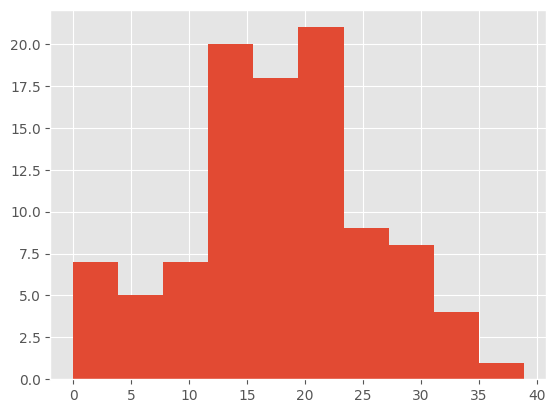

In [39]:
# смоделируем наблюдения СВ %НЕобслуженных заявок и построим эмпирическое распределение
nn = 100
sample = []
for _ in range(nn):
    query_flow = (np.random.random(60) < p_query_per_min) * 1
    serviced_query_flow = calc_serviced_query_flow(query_flow)
    sample.append(100* (1.0 - serviced_query_flow.sum() / query_flow.sum()))

plt.hist(sample);

## Идентификация параметров смеси распределений время жизни слушателей онлайн-курса

### Знакомство с онлайн курсом физтеха с Coursera.org
---

На портале Coursera.org размещался (с 2016 до 2022 года) курс физтеха "Обучение на размеченных данных". Курс является вторым в специализации "Машинное обучение". 1-й курс назывался "Математика и Python для анализа данных" (https://datasciencecourse.ru/).

Куратор курса выгрузил данные с онлайн-курса и попросил проанализировать и выявить узкие места курса (из оплативших курс только 6% смогли завершить 1-й курс и 10% - 2-й курс).

Описание курса:
```
{'course_name': 'Обучение на размеченных данных',
 'course_launch_ts': '2016-03-21 17:12:05.02',
 'modules_q': 5,
 'lessons_q': 18,
 'items_q': 171,
 'lecture': 81,
 'supplement': 48,
 'quiz': 17,
 'exam': 14,
 'others': 1,
 'graded programming': 7,
 'ungraded programming': 1,
 'phased peer': 2}
```

Структура курса:
```
Раздел 1. Машинное обучение и линейные модели
--> Урок 1. Знакомство с курсом
--> Урок 2. Знакомство с машинным обучением
--> Урок 3. Линейные модели
--> Урок 4. Немного обсуждений
Раздел 2. Борьба с переобучением и оценивание качества
--> Урок 1. Проблема переобучения и борьба с ней
--> Урок 2. Метрики качества
--> Урок 3. Библиотека scikit-learn. Введение
Раздел 3. Линейные модели: классификация и практические аспекты
--> Урок 1. Линейные модели: статистический взгляд
--> Урок 2. Практические рекомендации по линейным моделям
--> Урок 3. Библиотека scikit-learn. Продолжение
Раздел 4. Решающие деревья и композиции алгоритмов
--> Урок 1. Решающие деревья
--> Урок 2. Случайные леса
--> Урок 3. Градиентный бустинг
Раздел 5. Нейронные сети и обзор методов
--> Урок 1. Нейронные сети
--> Урок 2. Байесовская классификация и регрессия
--> Урок 3. Метрические алгоритмы и SVM
--> Урок 4. Теорема Байеса в машинном обучении
--> Урок 5. Бонусный урок
```

### Загрузка и первичный анализ статистики работы слушателей с курсом
---

Описание и статистика курса содержится в более чем 50 файлах. Мы рассмотрим статистику, связаннную с фактами работы слушателей с отдельными ресурсами курса.

Загрузим статистику работы слушателей с ресурасми курса:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

dir_path = '/content/drive/My Drive/Colab Notebooks/course_analysis/'
data_path = dir_path + 'course_description/'

course_progress = pd.read_csv(data_path + 'course_progress.csv', header=0)
course_progress

Mounted at /content/drive


,course_id,course_item_id,mipt_user_id,course_progress_state_type_id,course_progress_ts
0,-ebwLHHsEeWKsgrp3VnvAw,05Rhx,8ccd1f3418225079725045cdf302f02037a33ede,1,2017-06-04 02:32:38.412
1,-ebwLHHsEeWKsgrp3VnvAw,05Rhx,d461d6ee67283c5fb33d87d355aedb4bf4c7cb8c,1,2017-03-31 14:27:42.735
2,-ebwLHHsEeWKsgrp3VnvAw,05Rhx,7c11a9e2443b9c1b2ff5879712d01ecdef355ce8,2,2017-05-03 15:58:27.12
3,-ebwLHHsEeWKsgrp3VnvAw,05Rhx,74db9316637cd9e5a4d2a98213dd8f9ce2059b24,1,2017-03-30 18:43:14.531
4,-ebwLHHsEeWKsgrp3VnvAw,05Rhx,74cf68f7c9c1b721ff81c53cdf2d06cae4e5cfbd,1,2017-05-07 17:04:36.165
...,...,...,...,...,...
7992365,-ebwLHHsEeWKsgrp3VnvAw,b97pR,e3c16cebd71f6dbbb42c308c262b34c5ca6ecf84,2,2017-06-10 02:22:46.751
7992366,-ebwLHHsEeWKsgrp3VnvAw,bEMBK,4f3eb6aa1d4016d9b904de73c55fe48556382d78,1,2017-06-10 22:56:36.077
7992367,-ebwLHHsEeWKsgrp3VnvAw,hrGeE,a0e54677a0fe407078d075b38bcfcc6779c718f9,1,2017-06-10 09:10:36.298
7992368,-ebwLHHsEeWKsgrp3VnvAw,npZyq,e3c16cebd71f6dbbb42c308c262b34c5ca6ecf84,2,2017-06-10 11:27:42.863


In [2]:
# посмотрим сколько пользователей работало с курсом и со сколькими ресурсами

counts_by_user = course_progress.mipt_user_id.value_counts()
counts_by_user

e7c69569f2344fde5dd0553ba633565b580393d5    91121
efd15aa9c94cf74e55a1216a29d36f0f36e423a9    81767
73fa3c4d351fddb64db58ad811d4ffcfb78612e6    81478
be2c8eae6d024fc4a1ad6a5e6c7f4f55f7f867df    77612
34d6e6fd20c61710ea4408fe9aeb7ca29491b26e    70652
                                            ...  
b0357b032379da32bd8ac7a7940ee9146eb9756b        1
1b938a634b22fc72254ac7a0b9d645a58efec417        1
73030a5422196cecd537c02a5e94d2361e80603e        1
77f349ae80bea2ba876dbcb284fb13f392661284        1
7bf608306ffb03465c8290b23c10f75ad9771719        1
Name: mipt_user_id, Length: 6530, dtype: int64

In [3]:
counts_by_recources = course_progress.course_item_id.value_counts()
counts_by_recources

86bYU    2374777
t2Idc    1435044
gDCvW     699558
SwnIU     656190
JIhvh     411106
          ...   
zUmWt         27
Zmq44         24
neeZr          1
yshoe          1
WEEoh          1
Name: course_item_id, Length: 186, dtype: int64

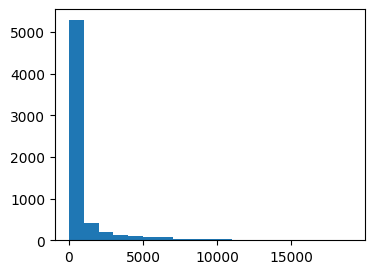

In [4]:
plt.figure(figsize=(4,3))

plt.hist(counts_by_user, bins=np.arange(0, 20000, 1000));

По количеству ресурсов, с которым поработал слушатель, можно понять как долго слушатель работал с курсом. С учетом того, что каждый слушатель на онлайн-курсе работает в своем темпе, основным параметром, относительно которого анализируют динамику обучения на онлайн-курсе является линейнка ресурсов, а не временная шкала.

Даже по данной неинформативной гистограмме видно, что непропорционально большим выбросом выглядит начальный столбик. Явно, что слушателей курса надо разделить на как минимум две категории:

- случайные слушатели: они записались на курс, чтобы просто посмотреть о чем курс или отдельные ресурсы; такие слушатели будут работать с небольшим количеством ресурсов;
- мотивированные слушатели; такие слушатели будут работать с курсом по мере возможностей, и с курса уйдут или по причине непонимания материала или из-за внешних обстоятельств (изменение приоритетов);

на самом деле есть еще категория
- наблюдатели: они только просматривают ресурсы, не пытаясь выполнить тесты и задания курса.

Понятно, что для каждой такой категории будет свой закон распределения вероятностей их "жизни на курсе", т.е. сколько действий они совершат с ресурсами.

### Выбор подходящих распределений
---

Попробуем экспоненциальное распределение, которое задается интенсивностью ухода с курса. Это распределение использует тот же параметр, что и закон Пуассона. Только для закона Пуассона этот параметр показывает кол-во событий в единицу времени, а для экспоненциального закона он показывает среднее время между наступлениями событий, обратное интенсивности наступления события:

$$\bar T = 1 / \lambda$$

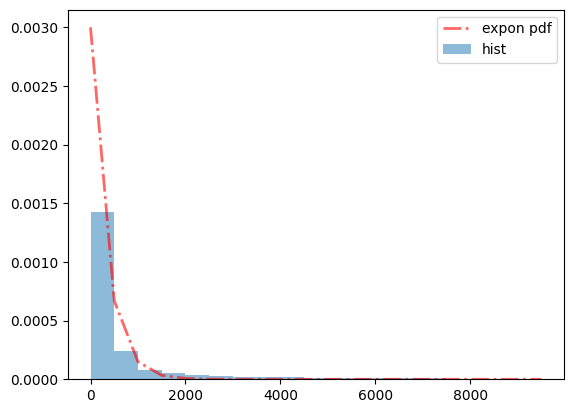

In [15]:
# Загрузим библиотеку с вероятностными законами распределения
from scipy.stats import expon

lamda = 0.003
Tmean = 1 / lamda
x = np.arange(0, 10000, 500)

fig, ax = plt.subplots(1, 1)
ax.plot(x, expon.pdf(x, scale=Tmean), 'r-.', lw=2, alpha=0.6, label='expon pdf')
ax.hist(counts_by_user, density=True,  bins=np.arange(0, 10000, 500), histtype='stepfilled', alpha=0.5, label='hist');
ax.legend();

получилось не очень. Если пользоваться этим распределением, то получается в среднем среднее время жизни слушателя на курсе примерно ${Tmean} \approx 300$ просмотров ресурсов.

Попробуем провести преобразование параметра "время жизни". Предположим, что данный параметр является произведением множества других случайных параметров (мотивация * условия * уровень подготовки ...). ТОгда имеет смысл прологарифмировать данную величину, чтобы получить сумму случайных величин, которая имеет распределение, близкое к нормальному.

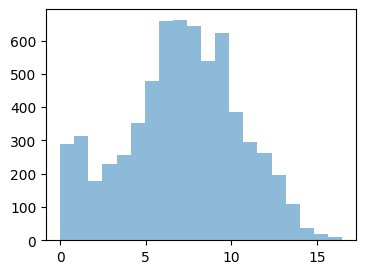

In [6]:
log_counts_by_user = np.log2(counts_by_user)

plt.figure(figsize=(4,3))

plt.hist(log_counts_by_user, bins=20, histtype='stepfilled', alpha=0.5);

видим, что это действительно более похоже на известные законы распределения и более четко выражены отдельные части этой смеси распределений.

Похоже, что мы угадали, что время жизни является произведением нескольких факторов. Фактически это означает, что вероятность ухода с курса обратно пропорциональна времени, проведенному на курсе.

явно здесь имеется как минимум смесь из двух распределений. Обозначим эти части

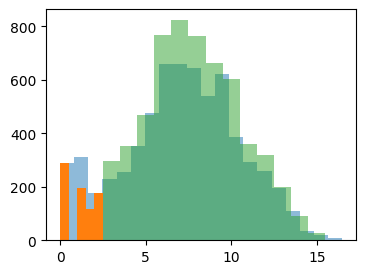

In [7]:
plt.figure(figsize=(4,3))

plt.hist(log_counts_by_user, bins=20, histtype='stepfilled', alpha=0.5);
plt.hist(log_counts_by_user, bins=np.arange(0, 2.6, 0.5));
plt.hist(log_counts_by_user, bins=np.arange(2.5, 16.0, 1), alpha=0.5);

### Идентификация смеси распределения
---

Постулируем смесь из двух распределений:
- нормальное распределение со средним около 7;
- экспоненциальное распределение, описывающее левый хвост (поведение случайных слушателей).

Подберем сначала параметры нормального распределения

### ВОПРОС.
---
Почему биномиальное распределение или распределение Пуассона здесь не удобны нам для описания вероятностного закона?

In [8]:
log_counts_by_user.mean()

7.062661692801274

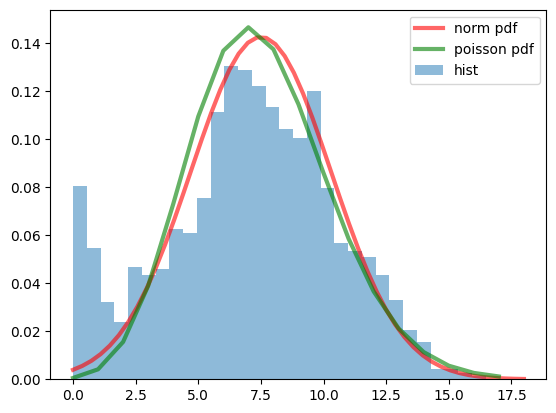

In [17]:
# Загрузим библиотеку с вероятностными законами распределения
from scipy.stats import expon, norm, poisson

x = np.linspace(0, 18, 50)
x_int = range(18)

mu = 7.5
sigma = 2.8

fig, ax = plt.subplots(1, 1)
ax.plot(x, norm.pdf(x, loc=mu, scale=sigma), 'r-', lw=3, alpha=0.6, label='norm pdf')
ax.plot(x_int, poisson.pmf(x_int, mu), 'g-', lw=3, alpha=0.6, label='poisson pdf')
ax.hist(log_counts_by_user, density=True, bins=30, histtype='stepfilled', alpha=0.5, label='hist');
ax.legend();

когда мы подбираем смесь, нам надо будет одновременно подбирать и параметры отдельных распределений и долю объектов, которые описываются тем или иным распределением

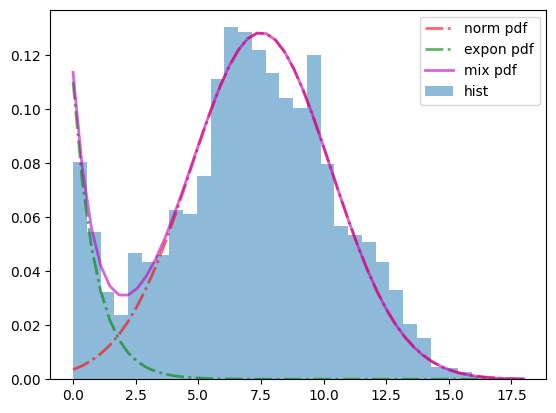

In [10]:
# параметры нормального распределения (ранее подобрали)
mu = 7.5
sigma = 2.8
# параметр экспоненциального распределения
lamda = 1.1
Tm = 1 / lamda
# доля случайных слушателей
p_exp = 0.1

fig, ax = plt.subplots(1, 1)
ax.plot(x, (1 - p_exp) * norm.pdf(x, loc=mu, scale=sigma), 'r-.', lw=2, alpha=0.6, label='norm pdf')
ax.plot(x, p_exp * expon.pdf(x, scale=Tm), 'g-.', lw=2, alpha=0.6, label='expon pdf')
ax.plot(x, (1 - p_exp) * norm.pdf(x, loc=mu, scale=sigma) + p_exp * expon.pdf(x, scale=Tm),
        'm-', lw=2, alpha=0.6, label='mix pdf')
ax.hist(log_counts_by_user, density=True, bins=30, histtype='stepfilled', alpha=0.5, label='hist');
ax.legend();

Попробуем учесть деление НЕслучайных слушателей на две категории - наблюдателей, которым не важно выполнить задания курса и получить сертификат и реально замотивированных на успешное завершение курса. Опишем их как смесь двух нормальных распределений

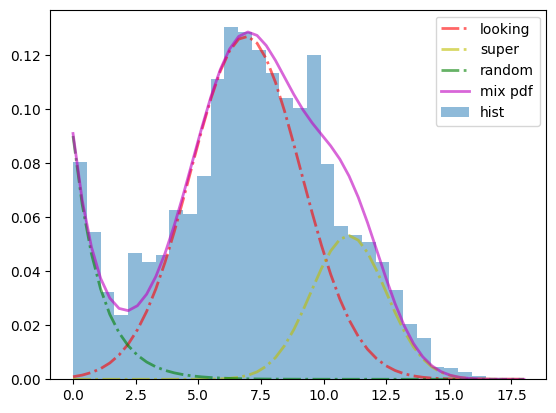

In [11]:
# параметры нормального распределения для "наблюдателей"
mu1 = 6.9
sigma1 = 2.2
# параметры нормального распределения для "мотивированных"
mu2 = 11.0
sigma2 = 1.5
# параметр экспоненциального распределения
lamda = 0.9
Tm = 1 / lamda

# доля случайных слушателей
p_exp = 0.1
# доля мотивированных слушателей
p_2 = 0.2
p_1 = 1 - p_exp - p_2

fig, ax = plt.subplots(1, 1)
ax.plot(x, p_1 * norm.pdf(x, loc=mu1, scale=sigma1), 'r-.', lw=2, alpha=0.6, label='looking')
ax.plot(x, p_2 * norm.pdf(x, loc=mu2, scale=sigma2), 'y-.', lw=2, alpha=0.6, label='super')
ax.plot(x, p_exp * expon.pdf(x, scale=Tm), 'g-.', lw=2, alpha=0.6, label='random')
ax.plot(x, p_1 * norm.pdf(x, loc=mu1, scale=sigma1) + p_2 * norm.pdf(x, loc=mu2, scale=sigma2) +
        p_exp * expon.pdf(x, scale=Tm), 'm-', lw=2, alpha=0.6, label='mix pdf')
ax.hist(log_counts_by_user, density=True, bins=30, histtype='stepfilled', alpha=0.5, label='hist');
ax.legend();

# Resume
---
